In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import sentencepiece as spm
import math
import re
from tqdm.notebook import tqdm
import random
from torch.nn.utils.rnn import pad_sequence
from gensim.models import KeyedVectors
import gensim.downloader as api

In [2]:
chat_path = "/Users/jian_lee/Desktop/aiffel/data/Chatbot/ChatbotData (1).csv"

In [3]:
# 데이터 정제 및 토큰화
def clean_corpus(chat_path):
    # CSV 파일 로드
    df = pd.read_csv(chat_path)
    
    # 한국어 (Q), 영어 (A) 컬럼 선택
    kor = df["Q"].tolist()
    eng = df["A"].tolist()
    
    assert len(kor) == len(eng), "한국어와 영어 코퍼스의 크기가 일치하지 않습니다!"
    
    # 중복 제거 전 데이터 크기
    original_size = len(kor)
    
    # 중복 제거 (병렬 데이터를 튜플로 묶어 처리)
    unique_pairs = set(zip(kor, eng))
    
    # 중복 제거 후 데이터 크기
    cleaned_size = len(unique_pairs)
    
    # 리스트로 변환
    cleaned_corpus = list(unique_pairs)
    
    # 중복 제거 확인
    print(f"중복 제거 전 데이터 크기: {original_size}")
    print(f"중복 제거 후 데이터 크기: {cleaned_size}")
    
    # 랜덤 샘플 10개 출력
    print("\n랜덤 샘플 10개:")
    sample_size = min(10, cleaned_size)  # 데이터가 10개 미만일 경우 대비
    random_samples = random.sample(cleaned_corpus, sample_size)
    
    for i, (kor_sample, eng_sample) in enumerate(random_samples, 1):
        print(f"{i}. 한국어: {kor_sample} | 영어: {eng_sample}")

    return cleaned_corpus

# 함수 실행
cleaned_corpus = clean_corpus(chat_path)

중복 제거 전 데이터 크기: 11823
중복 제거 후 데이터 크기: 11750

랜덤 샘플 10개:
1. 한국어: 나라도 내 마음을 지켜야 하는 거야 | 영어: 본인 마음 좀 지켜주세요.
2. 한국어: 거짓말 하는 썸남 말해? | 영어: 거짓말은 습관이에요.
3. 한국어: 종교가 다른 짝남과 연애할수 있을까? | 영어: 사랑은 종교를 뛰어넘을 수 있을 거예요.
4. 한국어: 10년 연애. 헤어졌습니다. | 영어: 더 공허함이 크시겠네요.
5. 한국어: 오늘은 2년전 그녀에게 고백했던날 | 영어: 아픔을 헤아려도 달라지는 건 없어요.
6. 한국어: 연말이라 그런지 | 영어: 외롭겠지만 즐겁게 보내보아요.
7. 한국어: 나 미쳤나바 | 영어: 그럴 수 있어요.
8. 한국어: 심심한데 뭐하면 좋을까 | 영어: 저랑 이야기해요.
9. 한국어: 고민이 많은데 표현을 못하겠어 | 영어: 글로 적어보세요. 조금이나마 정리가 될 거예요.
10. 한국어: 겁난다 | 영어: 용기 내보세요.


In [4]:
# 정규식 패턴을 사전 컴파일하여 속도 최적화
TOKEN_CLEANER = re.compile(r"[^a-zA-Zㄱ-ㅎ가-힣.,!? ]")
PUNCTUATION_SPACING = re.compile(r"([.,!?])")
MULTI_SPACE_CLEANER = re.compile(r"\s+")

def preprocess_sentence(sentence):
    """
    문장을 정제하는 함수
    1. 소문자로 변환
    2. 불필요한 문자 제거
    3. 문장부호 양옆에 공백 추가
    4. 연속된 공백을 하나로 변환
    """
    sentence = sentence.lower()  # 소문자 변환
    sentence = TOKEN_CLEANER.sub("", sentence)  # 불필요한 문자 제거
    sentence = PUNCTUATION_SPACING.sub(r" \1 ", sentence)  # 문장부호 공백 추가
    sentence = MULTI_SPACE_CLEANER.sub(" ", sentence)  # 다중 공백 제거
    sentence = sentence.strip()  # 앞뒤 공백 제거
    return sentence

# 전처리된 랜덤 샘플 10개 출력
def check_preprocessing_samples(cleaned_corpus):
    sample_size = min(10, len(cleaned_corpus))  # 데이터가 10개 미만일 경우 대비
    random_samples = random.sample(cleaned_corpus, sample_size)

    print("\n랜덤 샘플 10개 (전처리 전 -> 전처리 후):")
    for i, (kor_sample, eng_sample) in enumerate(random_samples, 1):
        preprocessed_kor = preprocess_sentence(kor_sample)
        preprocessed_eng = preprocess_sentence(eng_sample)
        print(f"{i}. 한국어: {kor_sample} -> {preprocessed_kor}")
        print(f"   영어: {eng_sample} -> {preprocessed_eng}")

# 함수 실행 (cleaned_corpus가 이전 단계에서 생성된 것)
check_preprocessing_samples(cleaned_corpus)


랜덤 샘플 10개 (전처리 전 -> 전처리 후):
1. 한국어: 연락죽어도 안올텐데 매일 기다려 -> 연락죽어도 안올텐데 매일 기다려
   영어: 변해야할 시기를 놓친 걸 수도 있어요. -> 변해야할 시기를 놓친 걸 수도 있어요 .
2. 한국어: 좀 쉬면서 애기 키워야 할 듯 -> 좀 쉬면서 애기 키워야 할 듯
   영어: 좋은 곳에서 일하시나봐요. -> 좋은 곳에서 일하시나봐요 .
3. 한국어: 여친 있는 짝남이 너무 친절하게 대해줘서 착각하게 돼요. -> 여친 있는 짝남이 너무 친절하게 대해줘서 착각하게 돼요 .
   영어: 상대를 헷갈리게 하는 건 좋지 않아요. -> 상대를 헷갈리게 하는 건 좋지 않아요 .
4. 한국어: 장거리연애 이별 -> 장거리연애 이별
   영어: 애틋했던 만큼 아픔도 크겠죠. -> 애틋했던 만큼 아픔도 크겠죠 .
5. 한국어: 날 버려달라고 -> 날 버려달라고
   영어: 슬프네요. -> 슬프네요 .
6. 한국어: 진급 누락됐어 -> 진급 누락됐어
   영어: 다음에는 꼭 진급할 거예요. -> 다음에는 꼭 진급할 거예요 .
7. 한국어: 뭔가 무섭다 -> 뭔가 무섭다
   영어: 어흥!! 호랑이보다 무섭나요? -> 어흥 ! ! 호랑이보다 무섭나요 ?
8. 한국어: 여자친구가 음식을 너무 적게 먹어 -> 여자친구가 음식을 너무 적게 먹어
   영어: 과식보다 소식이 좋죠. -> 과식보다 소식이 좋죠 .
9. 한국어: 내가 좋아하는 애를 내 친구가 계속 욕하는게 맘에 안들어. -> 내가 좋아하는 애를 내 친구가 계속 욕하는게 맘에 안들어 .
   영어: 특별한 이유가 없다면 서운함을 전해보세요. -> 특별한 이유가 없다면 서운함을 전해보세요 .
10. 한국어: 외롭지만 혼자 걸을수 있어_조성모 -> 외롭지만 혼자 걸을수 있어조성모
   영어: 제가 뒤에서 지켜드릴게요. -> 제가 뒤에서 지켜드릴게요 .


In [5]:
# 단어 사전 크기 설정
SRC_VOCAB_SIZE = 20000  # 한국어 vocab 크기
TGT_VOCAB_SIZE = 20000  # 영어 vocab 크기

def generate_tokenizer(corpus, vocab_size=20000, lang="ko", pad_id=0, bos_id=1, eos_id=2, unk_id=3):
    """
    SentencePiece 토크나이저 학습 및 로드
    - corpus: 학습할 말뭉치 (리스트 형태)
    - vocab_size: 단어 사전 크기 (데이터 크기에 맞게 동적으로 설정)
    - lang: 언어 식별자 (ko/en 등)
    """
    
    # 실제 데이터에서 가능한 단어 수 확인 후 vocab_size 조정
    max_vocab_limit = 6989 if lang == "ko" else 4563  # 한국어와 영어의 최대 vocab 크기 지정
    actual_vocab_size = min(vocab_size, len(set(' '.join(corpus).split())), max_vocab_limit)
    
    print(f"{lang} 단어 사전 크기 조정: {actual_vocab_size}")

    # SentencePiece 학습을 위해 임시 파일 생성
    temp_file = f"{lang}_corpus.txt"
    with open(temp_file, "w", encoding="utf-8") as f:
        f.writelines(sentence + "\n" for sentence in corpus)

    # SentencePiece 모델 학습
    model_prefix = f"{lang}_tokenizer"

    spm.SentencePieceTrainer.train(
        input=temp_file,  # 파일을 사용하여 학습
        model_prefix=model_prefix,
        vocab_size=actual_vocab_size,
        pad_id=pad_id,
        bos_id=bos_id,
        eos_id=eos_id,
        unk_id=unk_id,
        model_type="unigram"
    )
    
    # 학습된 모델 로드
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f"{model_prefix}.model")
    
    return tokenizer

# 문장 정제 및 토큰화
kor_corpus = [preprocess_sentence(k) for k, _ in cleaned_corpus]
eng_corpus = [preprocess_sentence(e) for _, e in cleaned_corpus]

# 토크나이저 학습 (데이터 크기에 맞게 vocab_size 자동 조정)
ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

# 필터링 및 텐서 변환
src_corpus = []
tgt_corpus = []

for k_sent, e_sent in tqdm(zip(kor_corpus, eng_corpus), total=len(kor_corpus)):
    src_tokens = ko_tokenizer.EncodeAsIds(k_sent)
    tgt_tokens = en_tokenizer.EncodeAsIds(e_sent)
    
    if len(src_tokens) <= 50 and len(tgt_tokens) <= 50:
        src_corpus.append(torch.LongTensor(src_tokens))
        tgt_corpus.append(torch.LongTensor(tgt_tokens))

# PyTorch에서 패딩 적용
pad_id = 0
enc_train = pad_sequence(src_corpus, batch_first=True, padding_value=pad_id)
dec_train = pad_sequence(tgt_corpus, batch_first=True, padding_value=pad_id)

print("enc_train shape:", enc_train.shape)
print("dec_train shape:", dec_train.shape)

ko 단어 사전 크기 조정: 6989
en 단어 사전 크기 조정: 4563


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: ko_corpus.txt
  input_format: 
  model_prefix: ko_tokenizer
  model_type: UNIGRAM
  vocab_size: 6989
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  d

  0%|          | 0/11750 [00:00<?, ?it/s]

enc_train shape: torch.Size([11750, 24])
dec_train shape: torch.Size([11750, 37])


In [6]:
# 문장 정제 및 토큰화 (리스트 컴프리헨션 활용)
kor_corpus = [preprocess_sentence(k) for k, _ in cleaned_corpus]
eng_corpus = [preprocess_sentence(e) for _, e in cleaned_corpus]

# SentencePiece 토크나이저 학습
ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus), "한국어와 영어 문장 수가 일치하지 않습니다!"

# 토큰 길이가 50 이하인 문장만 필터링 (tqdm 최적화)
for k_sent, e_sent in tqdm(zip(kor_corpus, eng_corpus), total=len(kor_corpus)):
    src_tokens = ko_tokenizer.EncodeAsIds(k_sent)
    tgt_tokens = en_tokenizer.EncodeAsIds(e_sent)
    
    if len(src_tokens) <= 50 and len(tgt_tokens) <= 50:
        src_corpus.append(torch.LongTensor(src_tokens))
        tgt_corpus.append(torch.LongTensor(tgt_tokens))

# PyTorch에서 패딩 적용 (post-padding)
pad_id = 0  # 패딩 값 명확하게 지정
enc_train = pad_sequence(src_corpus, batch_first=True, padding_value=pad_id)
dec_train = pad_sequence(tgt_corpus, batch_first=True, padding_value=pad_id)

# 데이터 확인
print("enc_train shape:", enc_train.shape)  # (batch_size, max_seq_len)
print("dec_train shape:", dec_train.shape)  # (batch_size, max_seq_len)

ko 단어 사전 크기 조정: 6989
en 단어 사전 크기 조정: 4563


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: ko_corpus.txt
  input_format: 
  model_prefix: ko_tokenizer
  model_type: UNIGRAM
  vocab_size: 6989
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  d

  0%|          | 0/11750 [00:00<?, ?it/s]

enc_train shape: torch.Size([11750, 24])
dec_train shape: torch.Size([11750, 37])


- 로컬에서 ko.bin을 불러오는 과정에서 오류가 생겨 로컬 파일(ko.bin)을 사용하지 않고, 온라인에서 한국어 FastText 모델을 다운로드하여 사용

In [7]:
# 1. FastText 한국어 모델 다운로드 및 로드
print("FastText 한국어 모델을 다운로드 중...")
w2v_model = api.load("fasttext-wiki-news-subwords-300")
print("모델 다운로드 완료!")

# 2. Lexical Substitution 함수 정의
def lexical_sub(sentence, w2v_model, top_n=5, prob=0.3):
    """
    주어진 문장에 대해 일부 단어를 유사한 단어로 치환하는 함수
    - sentence: 입력 문장 (string)
    - w2v_model: 사전 훈련된 Word2Vec/FastText 모델
    - top_n: 대체 후보 개수
    - prob: 단어 대체 확률
    """
    words = sentence.split()
    new_words = []

    for word in words:
        if word in w2v_model.key_to_index and random.random() < prob:  # 일정 확률로 대체
            similar_words = [w for w, _ in w2v_model.most_similar(word, topn=top_n)]
            new_words.append(random.choice(similar_words))  # 랜덤하게 대체
        else:
            new_words.append(word)  # 변경 없이 그대로 유지
    
    return " ".join(new_words)

# 3. 데이터 증강 진행
aug_que_corpus = [lexical_sub(q, w2v_model) for q in tqdm(kor_corpus, desc="Augmenting Questions")]
aug_ans_corpus = [lexical_sub(a, w2v_model) for a in tqdm(eng_corpus, desc="Augmenting Answers")]

# 4. 병렬 데이터 구성 (총 3배 증가)
expanded_que_corpus = (
    kor_corpus +        # 원본 질문 데이터
    aug_que_corpus +    # 질문을 Augmentation한 데이터
    kor_corpus          # 원본 질문 데이터 (답변 Augmentation과 매칭)
)

expanded_ans_corpus = (
    eng_corpus +        # 원본 답변 데이터
    eng_corpus +        # 원본 답변 데이터 (질문 Augmentation과 매칭)
    aug_ans_corpus      # 답변을 Augmentation한 데이터
)

# 5. 데이터 검증 - 랜덤 샘플 10개 출력
sample_size = min(10, len(expanded_que_corpus))
random_samples = random.sample(list(zip(expanded_que_corpus, expanded_ans_corpus)), sample_size)

print("\n랜덤 샘플 10개:")
for i, (q, a) in enumerate(random_samples, 1):
    print(f"{i}. Q: {q} | A: {a}")

# 6. 증가한 데이터 개수 출력
print("\n데이터 개수 비교")
print(f"원본 데이터 개수: {len(kor_corpus)}")
print(f"증가한 데이터 개수: {len(expanded_que_corpus)} (3배 증가)")

FastText 한국어 모델을 다운로드 중...
모델 다운로드 완료!


Augmenting Questions:   0%|          | 0/11750 [00:00<?, ?it/s]

Augmenting Answers:   0%|          | 0/11750 [00:00<?, ?it/s]


랜덤 샘플 10개:
1. Q: 운명인가 | A: 인연인가 봐요 .
2. Q: 홈쇼핑에서 자꾸 사게되네 | A: 지름신이 강림했나봅니다 ?
3. Q: 헤어지자는 말을 듣고 다시 잡고 또 그 다음의 연애 | A: 관계의 개선을 위해 함께 많은 노력을 해보세요 .
4. Q: 공시 준비하는데 연애하면 안되겠지 ? | A: 좋은 뭐가 중요한지 객관적으로 생각해보세요 .
5. Q: 사랑하는데 미지근한 거 같아 | A: 불타오르는 사랑만 사랑인건 아니에요 .
6. Q: 그녀도 나를 좋아했으면 좋겠는데 . | A: 그럼 더할 나위 없겠지요 .
7. Q: 내가 무의식 중에 무시하는 듯한 말투를 썼어 | A: 상대방을 존중해주세요 .
8. Q: 연인끼리 같이 샤워해 ? | A: 사람마다 다릅니다 .
9. Q: 연애 잘하는 사람 부러워 | A: 잘할 수 있어요 .
10. Q: 복수전공하고 싶어 | A: 학점 관리하세요 .

데이터 개수 비교
원본 데이터 개수: 11750
증가한 데이터 개수: 35250 (3배 증가)


In [8]:
from collections import Counter

#############################################
# 1. 답변 데이터에 <start>와 <end> 토큰 추가
#############################################
# expanded_ans_corpus는 기존에 구성된 증강 답변 데이터입니다.
expanded_ans_corpus_special = [f"<start> {ans} <end>" for ans in expanded_ans_corpus]

#############################################
# 2. 전체 데이터에 대한 단어 사전 구축
#############################################
# 질문과 답변 데이터를 모두 결합하여 전체 문장을 만듭니다.
combined_corpus = expanded_que_corpus + expanded_ans_corpus_special

# 간단히 공백 기준 tokenize (실제 상황에 따라 더 정교한 토크나이저 사용 가능)
all_tokens = []
for sentence in combined_corpus:
    all_tokens.extend(sentence.split())

# 각 토큰의 빈도 계산
token_counts = Counter(all_tokens)

# 특수 토큰 (패딩, 시작, 종료, 미등록)
special_tokens = ["<pad>", "<start>", "<end>", "<unk>"]

# 특수 토큰을 우선 추가한 후, 나머지 토큰들을 빈도 순 혹은 알파벳 순으로 정렬하여 vocabulary 구성
vocab = special_tokens + sorted([token for token in token_counts if token not in special_tokens])
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}

print("단어 사전 크기:", len(vocab))
# 예시로 사전의 일부 확인
print("단어 사전 예시:", list(word2idx.items())[:10])

#############################################
# 3. 문장 벡터화 함수 정의
#############################################
def vectorize_sentence(sentence, word2idx):
    # 토큰별로 인덱스로 변환, 사전에 없으면 <unk> 인덱스로 대체
    return [word2idx.get(token, word2idx["<unk>"]) for token in sentence.split()]

# 질문(encoder input) 벡터화
enc_train = [vectorize_sentence(sentence, word2idx) for sentence in expanded_que_corpus]
# 답변(Decoder input) 벡터화 - special 토큰이 추가된 답변 사용
dec_train = [vectorize_sentence(sentence, word2idx) for sentence in expanded_ans_corpus_special]

#############################################
# 4. 패딩 함수 정의 (옵션)
#############################################
def pad_sequences(sequences, pad_value, max_length=None):
    if max_length is None:
        max_length = max(len(seq) for seq in sequences)
    padded_sequences = []
    for seq in sequences:
        padded_seq = seq + [pad_value] * (max_length - len(seq))
        padded_sequences.append(padded_seq)
    return padded_sequences

# <pad> 토큰의 인덱스
pad_value = word2idx["<pad>"]

# enc_train과 dec_train을 최대 길이에 맞춰 패딩 처리
enc_train_padded = pad_sequences(enc_train, pad_value)
dec_train_padded = pad_sequences(dec_train, pad_value)

print("Vectorized encoder input (예시):", enc_train_padded[0])
print("Vectorized decoder input (예시):", dec_train_padded[0])

단어 사전 크기: 20550
단어 사전 예시: [('<pad>', 0), ('<start>', 1), ('<end>', 2), ('<unk>', 3), ('!', 4), ('"', 5), ('*', 6), (',', 7), ('-', 8), ('.', 9)]
Vectorized encoder input (예시): [7429, 12950, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Vectorized decoder input (예시): [1, 1915, 9, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [10]:
#############################################
# Positional Encoding
#############################################
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

#############################################
# Encoder 레이어 (attention weight 반환)
#############################################
class TransformerEncoderLayerWithAttn(nn.Module):
    def __init__(self, d_model, num_heads, dff, dropout=0.1):
        super(TransformerEncoderLayerWithAttn, self).__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, 
                                               dropout=dropout, batch_first=True)
        self.linear1 = nn.Linear(d_model, dff)
        self.linear2 = nn.Linear(dff, d_model)
        self.dropout_attn = nn.Dropout(dropout)
        self.dropout_ff = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.activation = nn.ReLU()

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        attn_output, attn_weights = self.self_attn(src, src, src, 
                                                   attn_mask=src_mask, 
                                                   key_padding_mask=src_key_padding_mask, 
                                                   need_weights=True)
        src = self.norm1(src + self.dropout_attn(attn_output))
        ff_output = self.linear2(self.dropout_ff(self.activation(self.linear1(src))))
        src = self.norm2(src + ff_output)
        return src, attn_weights

#############################################
# Decoder 레이어 (attention weight 반환)
#############################################
class TransformerDecoderLayerWithAttn(nn.Module):
    def __init__(self, d_model, num_heads, dff, dropout=0.1):
        super(TransformerDecoderLayerWithAttn, self).__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, 
                                               dropout=dropout, batch_first=True)
        self.enc_dec_attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, 
                                                  dropout=dropout, batch_first=True)
        self.linear1 = nn.Linear(d_model, dff)
        self.linear2 = nn.Linear(dff, d_model)
        self.dropout_self = nn.Dropout(dropout)
        self.dropout_enc_dec = nn.Dropout(dropout)
        self.dropout_ff = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.activation = nn.ReLU()

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None,
                tgt_key_padding_mask=None, memory_key_padding_mask=None):
        self_attn_output, self_attn_weights = self.self_attn(tgt, tgt, tgt, 
                                                              attn_mask=tgt_mask, 
                                                              key_padding_mask=tgt_key_padding_mask,
                                                              need_weights=True)
        tgt = self.norm1(tgt + self.dropout_self(self_attn_output))
        enc_dec_attn_output, enc_dec_attn_weights = self.enc_dec_attn(tgt, memory, memory, 
                                                                      attn_mask=memory_mask,
                                                                      key_padding_mask=memory_key_padding_mask,
                                                                      need_weights=True)
        tgt = self.norm2(tgt + self.dropout_enc_dec(enc_dec_attn_output))
        ff_output = self.linear2(self.dropout_ff(self.activation(self.linear1(tgt))))
        tgt = self.norm3(tgt + ff_output)
        return tgt, self_attn_weights, enc_dec_attn_weights

#############################################
# 전체 Transformer 모델
#############################################
class TransformerWithAttn(nn.Module):
    def __init__(self, num_layers=2, d_model=512, num_heads=8, dff=2048, 
                 input_vocab_size=20000, target_vocab_size=20000, dropout=0.1):
        super(TransformerWithAttn, self).__init__()
        self.encoder_embedding = nn.Embedding(input_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(target_vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, dropout)
        
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayerWithAttn(d_model, num_heads, dff, dropout) for _ in range(num_layers)
        ])
        self.decoder_layers = nn.ModuleList([
            TransformerDecoderLayerWithAttn(d_model, num_heads, dff, dropout) for _ in range(num_layers)
        ])
        
        self.final_layer = nn.Linear(d_model, target_vocab_size)
        # 선택 사항: 임베딩 가중치 공유 (Tied Embeddings)
        self.final_layer.weight = self.decoder_embedding.weight

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, memory_mask=None,
                src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        # 입력은 이미 동일한 device에 있다고 가정합니다.
        src_emb = self.pos_encoding(self.encoder_embedding(src))
        tgt_emb = self.pos_encoding(self.decoder_embedding(tgt))
        
        enc_attns = []
        for layer in self.encoder_layers:
            src_emb, attn_weights = layer(src_emb, src_mask, src_key_padding_mask)
            enc_attns.append(attn_weights)
        
        dec_attns, dec_enc_attns = [], []
        for layer in self.decoder_layers:
            tgt_emb, self_attn_weights, enc_dec_attn_weights = layer(
                tgt_emb, src_emb, tgt_mask, memory_mask, tgt_key_padding_mask, memory_key_padding_mask)
            dec_attns.append(self_attn_weights)
            dec_enc_attns.append(enc_dec_attn_weights)
        
        final_output = self.final_layer(tgt_emb)
        return final_output, enc_attns, dec_attns, dec_enc_attns

In [12]:
#############################################
# 디바이스 자동 감지 (GPU / MPS / CPU)
#############################################
device = torch.device(
    "cuda" if torch.cuda.is_available() else "mps" if hasattr(torch.backends, "mps") and torch.backends.mps.is_available() else "cpu"
)
print(f"Using device: {device}")

#############################################
# 실제 챗봇 모델 (Transformer 기반) 사용
#############################################
transformer = TransformerWithAttn(
    num_layers=2,
    d_model=512,  # 실제 모델의 d_model과 일치해야 함
    num_heads=8,
    dff=2048,
    input_vocab_size=SRC_VOCAB_SIZE,
    target_vocab_size=TGT_VOCAB_SIZE,
    dropout=0.1
).to(device)

#############################################
# Learning Rate Scheduler (논문 기반)
#############################################
class CustomSchedule(optim.lr_scheduler.LambdaLR):
    def __init__(self, optimizer, d_model, warmup_steps=4000, last_epoch=-1):
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        super(CustomSchedule, self).__init__(optimizer, lambda step: self.lr_lambda(step), last_epoch=last_epoch)

    def lr_lambda(self, step):
        # step이 0인 경우를 방지
        step = max(1, step)
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        return (self.d_model ** -0.5) * min(arg1, arg2)

# 하이퍼파라미터 설정
d_model = 512
warmup_steps = 4000

# 옵티마이저 및 스케줄러 설정
optimizer = optim.AdamW(transformer.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.01)
scheduler = CustomSchedule(optimizer, d_model=512, warmup_steps=4000)

def print_lr(step):
    lr = scheduler.get_last_lr()[0]
    print(f"Step {step}: Learning Rate = {lr:.8f}")

# 예시: 스텝 별 학습률 확인
for step in [10, 100, 1000, 4000]:
    scheduler.step()
    print_lr(step)

Using device: mps
Step 10: Learning Rate = 0.00000000
Step 100: Learning Rate = 0.00000000
Step 1000: Learning Rate = 0.00000000
Step 4000: Learning Rate = 0.00000000


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


In [13]:
#############################################
# 손실 및 마스크 함수
#############################################
criterion = nn.CrossEntropyLoss(ignore_index=0, reduction='mean')

def loss_function(real, pred):
    return criterion(pred.view(-1, pred.shape[-1]), real.view(-1))

def create_padding_mask(seq):
    # (batch, seq_len) 모양의 boolean mask (입력 tensor와 동일한 device)
    return (seq == 0)

def create_look_ahead_mask(size):
    # 기본적으로 CPU에 생성되므로, 나중에 target의 device로 이동
    mask = torch.triu(torch.ones((size, size), dtype=torch.float32), diagonal=1)
    return mask.masked_fill(mask == 1, float('-inf'))

def generate_masks(src, tgt):
    """
    src: (batch, src_seq_len)
    tgt: (batch, tgt_seq_len)
    
    반환:
      src_key_padding_mask: (batch, src_seq_len)
      tgt_key_padding_mask: (batch, tgt_seq_len)
      dec_mask: (tgt_seq_len, tgt_seq_len) (look-ahead mask)
    """
    src_key_padding_mask = create_padding_mask(src)
    tgt_key_padding_mask = create_padding_mask(tgt)
    # 생성된 룩어헤드 mask를 tgt와 동일한 device로 이동
    dec_mask = create_look_ahead_mask(tgt.size(1)).to(tgt.device)
    return src_key_padding_mask, tgt_key_padding_mask, dec_mask

#############################################
# 학습 스텝 함수 정의
#############################################
def train_step(src, tgt, model, optimizer, criterion):
    model.train()  # 모델을 학습 모드로 전환
    src, tgt = src.to(device), tgt.to(device)
    
    # <BOS> 토큰을 제외한 입력 및 정답 생성
    tgt_input = tgt[:, :-1]
    gold = tgt[:, 1:].reshape(-1)
    
    # 마스크 생성: encoder와 decoder에 각각 key_padding_mask, decoder는 look-ahead mask (attn_mask)
    src_key_padding_mask, tgt_key_padding_mask, dec_mask = generate_masks(src, tgt_input)
    
    optimizer.zero_grad()
    predictions, _, _, _ = model(
        src, 
        tgt_input, 
        tgt_mask=dec_mask, 
        src_key_padding_mask=src_key_padding_mask, 
        tgt_key_padding_mask=tgt_key_padding_mask, 
        memory_key_padding_mask=src_key_padding_mask
    )
    
    # 손실 계산
    loss = criterion(predictions.view(-1, predictions.shape[-1]), gold)
    loss.backward()
    optimizer.step()
    
    return loss.item()

Epoch 1:   0%|          | 0/276 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 1 완료! 평균 Loss: 312.6515


Epoch 2:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch 2 완료! 평균 Loss: 312.6848


Epoch 3:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch 3 완료! 평균 Loss: 312.6713


Epoch 4:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch 4 완료! 평균 Loss: 312.6470


Epoch 5:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch 5 완료! 평균 Loss: 312.6400


Epoch 6:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch 6 완료! 평균 Loss: 312.7082


Epoch 7:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch 7 완료! 평균 Loss: 312.6543


Epoch 8:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch 8 완료! 평균 Loss: 312.7080


Epoch 9:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch 9 완료! 평균 Loss: 312.6758


Epoch 10:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch 10 완료! 평균 Loss: 312.6820


Epoch 11:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch 11 완료! 평균 Loss: 312.7040


Epoch 12:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch 12 완료! 평균 Loss: 312.6313


Epoch 13:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch 13 완료! 평균 Loss: 312.6487


Epoch 14:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch 14 완료! 평균 Loss: 312.6929


Epoch 15:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch 15 완료! 평균 Loss: 312.6900


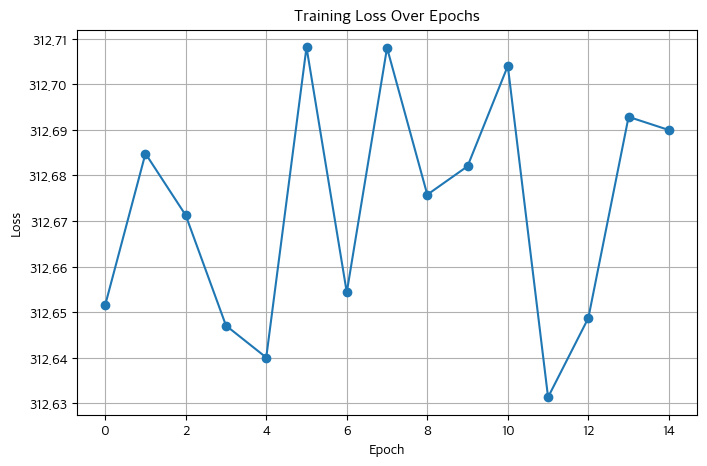


답변 결과:

입력: 지루하다, 놀러가고 싶어.
답변: 


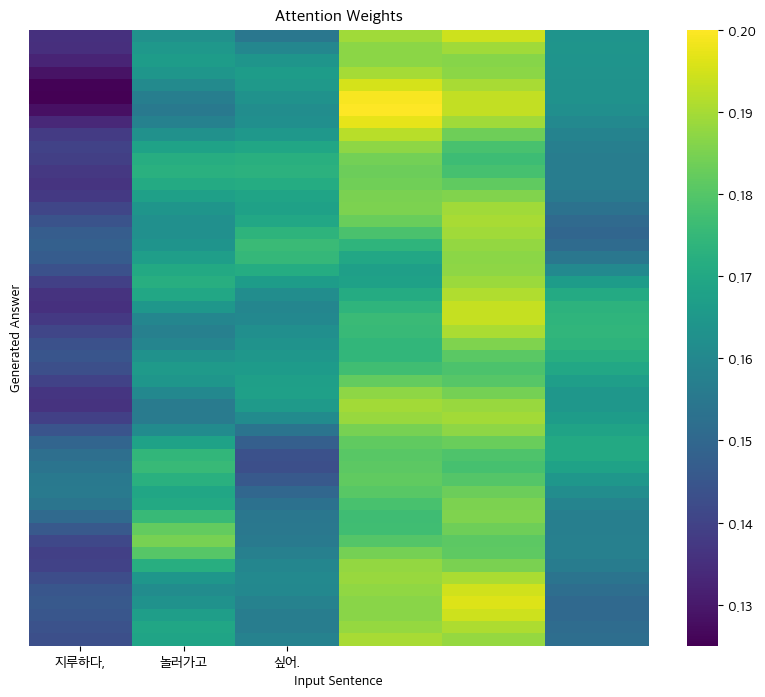


입력: 오늘 일찍 일어났더니 피곤하다.
답변: 


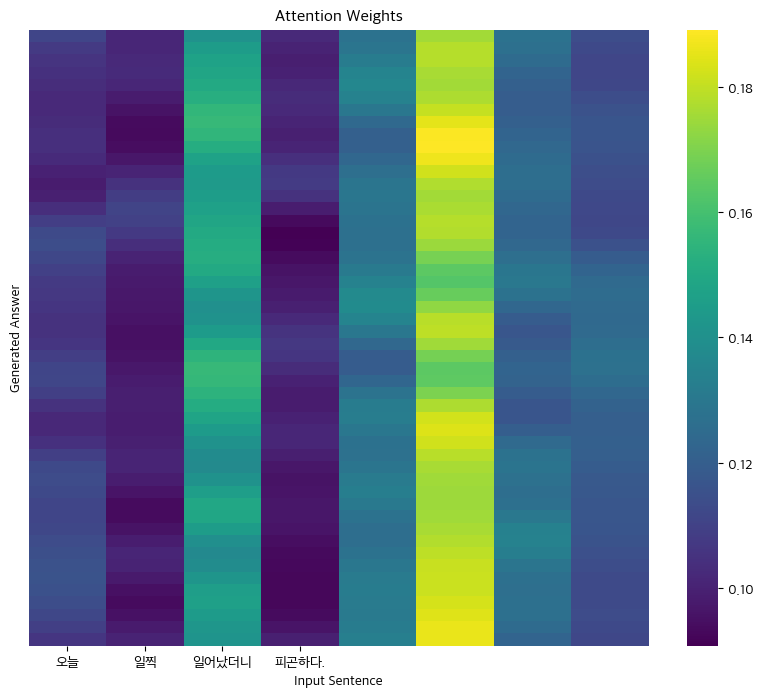


입력: 간만에 여자친구랑 데이트 하기로 했어.
답변: 


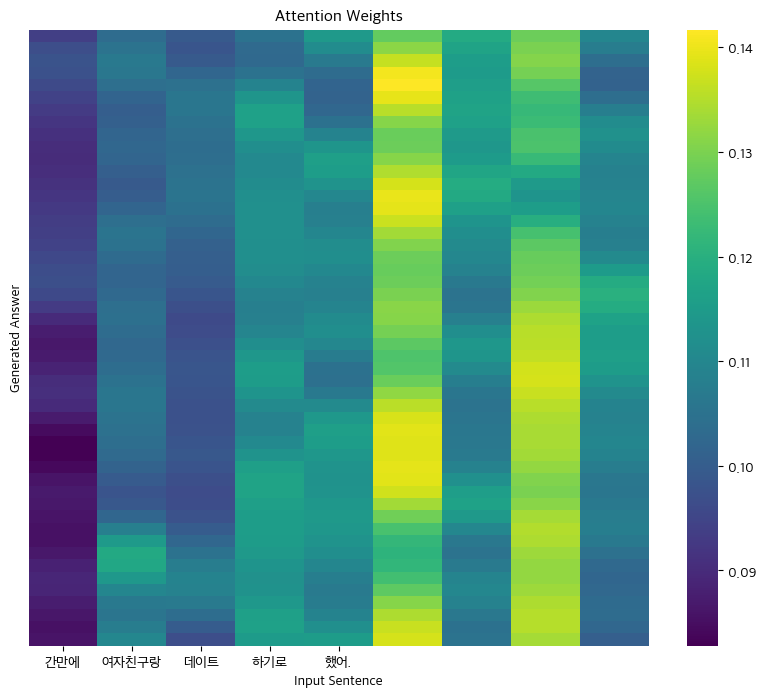


입력: 집에 있는다는 소리야.
답변: 


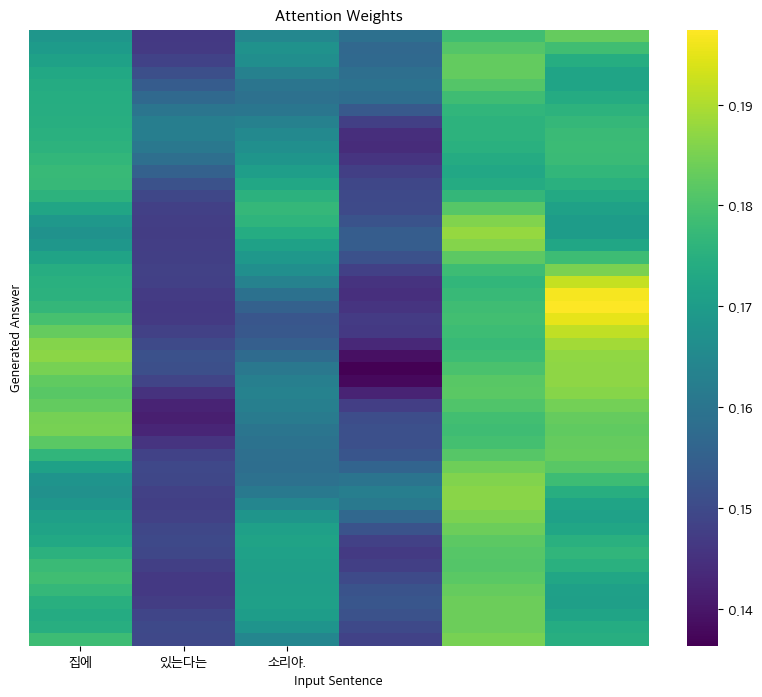

In [16]:
# 한글 지원 폰트 설정 (맥북 기준)
plt.rcParams["font.family"] = "Apple SD Gothic Neo"
# 만약 다른 한글 폰트를 사용하려면 아래와 같이 설정하세요.
# plt.rcParams["font.family"] = "NanumGothic"

#############################################
# Padding 및 Look-Ahead Mask 생성 함수
#############################################
def create_padding_mask(seq):
    # seq: (batch, seq_len)
    # 반환: (batch, seq_len) - key_padding_mask에 그대로 사용
    return (seq == 0)

def create_look_ahead_mask(size):
    # size: target sequence 길이
    mask = torch.triu(torch.ones((size, size)), diagonal=1)
    mask = mask.masked_fill(mask == 1, float('-inf'))
    return mask

def generate_masks(src, tgt):
    """
    src: (batch, src_seq_len)
    tgt: (batch, tgt_seq_len)
    
    반환:
    - src_key_padding_mask: (batch, src_seq_len)
    - tgt_key_padding_mask: (batch, tgt_seq_len)
    - dec_mask: (tgt_seq_len, tgt_seq_len) (look-ahead mask)
    """
    src_key_padding_mask = create_padding_mask(src)
    tgt_key_padding_mask = create_padding_mask(tgt)
    # 생성된 룩어헤드 mask를 tgt와 동일한 device로 이동
    dec_mask = create_look_ahead_mask(tgt.size(1)).to(tgt.device)
    return src_key_padding_mask, tgt_key_padding_mask, dec_mask

#############################################
# Transformer 모델 인스턴스 생성
#############################################
# SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, device, TransformerWithAttn 등은 이미 정의되어 있다고 가정합니다.
transformer = TransformerWithAttn(
    num_layers=2,
    d_model=512,
    num_heads=8,
    dff=2048,
    input_vocab_size=SRC_VOCAB_SIZE,
    target_vocab_size=TGT_VOCAB_SIZE,
    dropout=0.1
).to(device)

# 옵티마이저 설정
optimizer = torch.optim.AdamW(
    transformer.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.01
)

#############################################
# 답변 생성 및 Attention 반환 함수
#############################################
def generate_answer(sentence, model, src_tokenizer, tgt_tokenizer, max_length=50):
    model.eval()
    tokens = src_tokenizer.encode(sentence)
    src_tensor = torch.LongTensor(tokens).unsqueeze(0).to(device)
    
    tgt_tokens = [tgt_tokenizer.bos_id()]
    attention_weights_list = []
    
    vocab_size = tgt_tokenizer.GetPieceSize()  # 또는 tgt_tokenizer.vocab_size() 등, 사용 중인 토크나이저 API에 맞게 수정
    
    for _ in range(max_length):
        tgt_tensor = torch.LongTensor(tgt_tokens).unsqueeze(0).to(device)
        outputs, enc_attn, dec_attn, enc_dec_attn = model(src_tensor, tgt_tensor)
        final_output = outputs[0]
        
        # 마지막 토큰의 예측 결과를 가져옴 (1차원 tensor에서 마지막 요소 선택)
        next_token = final_output.argmax(dim=-1)[-1].item()
        
        # 예측된 토큰 ID가 유효한지 확인 (어휘 범위 내인지)
        if next_token < 0 or next_token >= vocab_size:
            next_token = tgt_tokenizer.eos_id()
        
        tgt_tokens.append(next_token)
        
        # 마지막 디코더 레이어의 인코더-디코더 Attention weight 저장
        attention_weights_list.append(enc_dec_attn[-1].squeeze(0).detach().cpu().numpy())
        
        if next_token == tgt_tokenizer.eos_id():
            break
            
    answer = tgt_tokenizer.decode(tgt_tokens)
    return answer, attention_weights_list

#############################################
# Attention 시각화 함수
#############################################
def plot_attention(attention, sentence, answer):
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_title("Attention Weights")
    
    sentence_tokens = sentence.split()
    answer_tokens = answer.split()
    
    sns.heatmap(attention, cmap="viridis", xticklabels=sentence_tokens, yticklabels=answer_tokens)
    plt.xlabel("Input Sentence")
    plt.ylabel("Generated Answer")
    plt.show()

#############################################
# 학습 스텝 함수 (mask 수정 적용)
#############################################
def train_step(src, tgt, model, optimizer, criterion):
    model.train()  # 모델을 학습 모드로 전환
    src, tgt = src.to(device), tgt.to(device)
    
    # <BOS> 토큰을 제외한 입력 및 정답 생성
    tgt_input = tgt[:, :-1]
    gold = tgt[:, 1:].reshape(-1)
    
    # mask 생성: encoder와 decoder에 각각 key_padding_mask, decoder는 look-ahead mask (attn_mask)
    src_key_padding_mask, tgt_key_padding_mask, dec_mask = generate_masks(src, tgt_input)
    
    optimizer.zero_grad()
    # model.forward의 인자에 맞게 keyword로 전달합니다.
    predictions, _, _, _ = model(
        src, 
        tgt_input, 
        tgt_mask=dec_mask, 
        src_key_padding_mask=src_key_padding_mask, 
        tgt_key_padding_mask=tgt_key_padding_mask, 
        memory_key_padding_mask=src_key_padding_mask
    )
    
    loss = criterion(predictions.view(-1, predictions.shape[-1]), gold)
    loss.backward()
    optimizer.step()
    
    return loss.item()

#############################################
# 학습 루프 및 관련 설정
#############################################
BATCH_SIZE = 128
EPOCHS = 15
loss_history = []

def pad_sequences(sequences, pad_value=0, max_length=None):
    if max_length is None:
        max_length = max(len(seq) for seq in sequences)
    padded_sequences = []
    for seq in sequences:
        padded_seq = seq + [pad_value] * (max_length - len(seq))
        padded_sequences.append(padded_seq)
    return padded_sequences

# 학습 루프 내에서 배치 단위 처리 예시:
for epoch in range(EPOCHS):
    total_loss = 0
    idx_list = list(range(0, len(enc_train), BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list, desc=f'Epoch {epoch + 1}')
    
    for batch, idx in enumerate(t):
        batch_src = enc_train[idx:idx+BATCH_SIZE]
        batch_tgt = dec_train[idx:idx+BATCH_SIZE]
        
        # 패딩 처리 (pad_value는 보통 <pad> 토큰의 인덱스, 여기서는 0으로 가정)
        batch_src = pad_sequences(batch_src, pad_value=0)
        batch_tgt = pad_sequences(batch_tgt, pad_value=0)
        
        batch_src = torch.tensor(batch_src, dtype=torch.long).to(device)
        batch_tgt = torch.tensor(batch_tgt, dtype=torch.long).to(device)
        
        batch_loss = train_step(batch_src, batch_tgt, transformer, optimizer, criterion)
        total_loss += batch_loss
        t.set_postfix(loss=total_loss / (batch + 1))
    
    avg_loss = total_loss / len(idx_list)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1} 완료! 평균 Loss: {avg_loss:.4f}")

#############################################
# Loss 그래프 시각화 함수
#############################################
def plot_loss(loss_history):
    plt.figure(figsize=(8, 5))
    plt.plot(loss_history, marker="o", linestyle="-")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.grid(True)
    plt.show()

# 학습 후 Loss 그래프 출력
plot_loss(loss_history)

#############################################
# 예문 답변 및 Attention 시각화
#############################################
examples = [
    "지루하다, 놀러가고 싶어.",
    "오늘 일찍 일어났더니 피곤하다.",
    "간만에 여자친구랑 데이트 하기로 했어.",
    "집에 있는다는 소리야."
]

print("\n답변 결과:")
for example in examples:
    answer, attention_weights_list = generate_answer(example, transformer, ko_tokenizer, en_tokenizer)
    print(f"\n입력: {example}")
    print(f"답변: {answer}")
    plot_attention(attention_weights_list[-1], example, answer)

- 이 Heatmap은 ‘출력 토큰별로 입력 토큰에 얼마나 집중했는지’를 시각적으로 표현한 것이며, 각 셀(cell)의 색이 짙거나 밝은 정도를 통해 “이 출력 토큰을 생성할 때, 어떤 입력 토큰에 중요한 비중을 두었는가?”를 파악할 수 있음.

---

## 회고

- 이미지가 보여주는 Attention 시각화 결과와 최종 답변을 보면, 모델이 실제로 유의미한 응답을 생성하지 못하고 있는 것으로 보임.
    - 학습 데이터 및 학습 과정 문제
    - 토크나이저 설정 및 어휘 사전 문제
    - 추론 방식(디코딩 전략) 문제


- 위 3가지가 유력한 문제사항이라고 추측하고 있음. 